In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

### General Variable names:
- d: drone object
- dp: droneport object
- fm: fleetmanager object
- sim: simulation object

### Useful functions

In [2]:
def get_distance(point_A, point_B):
    return np.linalg.norm(np.array(point_A)-np.array(point_B))

def optimize_drone_choice(cost, power):
    n = len(cost)
    x = cp.Variable((n, 1), nonneg=True)

    obj = cp.Minimize(cost@x)
    constr = []
    constr.append((power - cost)@x >= 0)
    constr.append(cp.sum(x) == 1)
    prob = cp.Problem(obj, constr)
    res = prob.solve()
    
    return np.argmax(x.value), res

### Customer Class

In [3]:
class Customer:
    def __init__(self, x, y, name):
        '''
        Inputs
            name: String
            x: x-coordinate of home
            y: y-coordinate of home
        '''
        self.name = name
        self.x = x
        self.y = y
    
    def get_location(self):
        return (self.x, self.y)
    
    def check_valid(self, bounds):
        pass
    
    def create_order(self):
        pass
    
    def get_current_order(self):
        pass

    def __repr__(self):
        return repr("Customer " + self.name + ". x: " + str(self.x) + " y: " + str(self.y))    

### Retailer Class

In [4]:
class Retailer:
    def __init__(self, x, y, name):
        self.x = x
        self.y = y
        self.name = name
        
    def __repr__(self):
        return repr("Retailer " + self.name + ". x: " + str(self.x) + " y: " + str(self.y))    
        
    def get_location(self):
        return (self.x, self.y)

### DronePort Class

In [5]:
class DronePort:
    def __init__(self, x, y, capacity=5):
        self.x = x
        self.y = y
        self.capacity = capacity
        self.fleet = []

    def __repr__(self):
        return repr("Drone Port. x: " + str(self.x) + " y: " + str(self.y))
    
    def get_location(self):
        return (self.x, self.y)
    
    def get_discharge_rates(self):
        return [d.discharge_rate for d in self.fleet]
    
    def get_power(self):
        return [d.get_power() for d in self.fleet]
    
    def create_fleet(self, drone_list):
        for d in drone_list:
            self.add_to_fleet(d)
            
    def add_to_fleet(self, drone):
        self.fleet.append(drone)
        
    def charge_fleet(self):
        for d in self.fleet:
            d.charge_power()
        pass
    
    def update_fleet(self, drone_list):
        if len(drone_list) != 0:
            self.fleet = drone_list
    

### Order Class - Important

#### Inputs:
- Customer object
- Retailer object
- Time (integer) e.g 0 representing what step in the simulation order is placed

#### Initialization
order = Order(customer, retailer, time)

In [6]:
class Order:
    def __init__(self, customer, retailer, time):
        self.customer = customer
        self.retailer = retailer
        self.status = "Open"
        self.time = time
        
    def update_status(self):
        pass
    
    def __repr__(self):
        repre = "Customer: " + self.customer.name + ". Retailer: " + self.retailer.name + ". Time: " + str(self.time)
        return repr(repre)

### Drone Class - Important

#### Inputs:
- x: initial x-coordinate 
- y: initial y-coordinate
- max_capacity: ignore
- max_power: max power (100 can traverse mostly anywhere, 50 runs into power constraints)
- starting_power: <= max power, can test response in power-constrained scenario
- charge_rate: currently 3 (so takes 33+1 steps to charge from 0 to 100)
- discharge_rate: currently 3 (so can take 16 steps on 50 max/starting power and 33 steps on 100 max/starting power)
- name: some letter of the alphabet, if you print a drone object, it shows the name

access any parameter of the object with 
- d.{parameter} e.g 
 - d.power

although some special getter functions exist e.g
- d.get_location()

#### Traversing distances
Each timestep, the drone traverses the shortest path between its current point and target point by taking a unit step in that direction. If closer to target than 1 unit step, it takes the remainder but still consumes one discharge_rate unit of power.

- step = min(remainder_distance, 1)

In [7]:
class Drone:
    def __init__(self, x, y, max_capacity, max_power, starting_power, charge_rate, discharge_rate, name):
        self.x = x
        self.y = y
        self.max_capacity = max_capacity
        self.max_power = max_power
        self.power = starting_power
        self.charge_rate = charge_rate
        self.discharge_rate = discharge_rate
        self.name = name
        self.status = "Disengaged"
        self.order = None
        self.waypoint_list = []
        pass
    
    def __repr__(self):
        return repr("Drone " + self.name)
    
    def consume_power(self):
        self.power = max(self.power - self.discharge_rate, 0)
    
    def charge_power(self):
        self.power = min(self.power + self.charge_rate, self.max_power)
    
    def get_capacity():
        return self.capacity
    
    def get_location(self):
        return (self.x, self.y)
    
    def set_location(self, x, y):
        self.x = x
        self.y = y
        
    def get_power(self):
        return self.power
        pass
    
    def assign_order(self, order):
        self.order = order
        self.update_waypoint_list(self.order.retailer.get_location())
        self.update_waypoint_list(self.order.customer.get_location())
        self.status = "Engaged"

    def switch_locations(self, waypoint):
        self.update_waypoint_list(waypoint)
        self.status = "Switching"
        
    def get_status(self):
        return self.status
    
    def set_status(self, status):
        self.status = status
    
    def get_order(self):
        return self.order
    
    def take_step(self):
        if self.status == "Disengaged":
            self.waypoint_list = []
            return
        
        if self.waypoint_list:
            self.set_current_target()
            self.update_current_target()
        current = np.array(self.get_location())
        target = np.array(self.get_current_target())
        normed_dist = np.linalg.norm(target - current)
        if normed_dist > 1:
            current = current + (target - current)/np.linalg.norm(target-current)
        else:
            current = current + (target - current)
            
        self.set_location(current[0], current[1])
        
        if normed_dist != 0:
            self.consume_power()            
            
    def update_waypoint_list(self, waypoint):
        self.waypoint_list.append(waypoint)
    
    def update_current_target(self):
        if self.get_location() == self.get_current_target():
            self.waypoint_list.pop(0)
              
    def set_current_target(self):
        self.target_x, self.target_y = self.waypoint_list[0]
        
    def get_current_target(self):
        return (self.target_x, self.target_y)

### FleetManager Class - Important

#### Inputs:
- dp1: droneport 1 (currently located at (5, 5)
- dp2: droneport 2 (currently located at (-5, 5)

object is initialized within Simulation

#### Fleet:
Currently, fleet consists of 10 drones initialized in line 6 below. 5 drones at dp1 have 100 max power and starting power. 5 drones at dp2 have 50 max power and starting power. 

In [8]:
class FleetManager:
    def __init__(self, dp1, dp2):
        self.dp1 = dp1
        self.dp2 = dp2
        name = dict(zip([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]))
        self.fleet = [Drone(*dp1.get_location(), None, 100, 100, 3, 3, name[i]) for i in range(5)] + \
                    [Drone(*dp2.get_location(), None, 50, 50, 3, 3, name[i]) for i in range(5, 10)]
        self.available_fleet = [_ for _ in self.fleet]
        self.locations_over_time = []
        self.powers_over_time = []
        self.orders_over_time = []
        pass
    
    def get_locations(self):
        return [d.get_location() for d in self.available_fleet]
        pass
    
    def get_discharge_rates(self):
        return [d.discharge_rate for d in self.available_fleet]
    
    def get_power(self):
        return [d.get_power() for d in self.available_fleet]
    
    def update_dp_fleets(self):
        #keeps track of which drones are at which droneport for charging purposes
        dp1_fleet = []
        dp2_fleet = []
        for d in self.fleet:
            if d.get_location() == self.dp1.get_location():
                dp1_fleet.append(d)
            elif d.get_location() == self.dp2.get_location():
                dp2_fleet.append(d)
        self.dp1.update_fleet(dp1_fleet)
        self.dp2.update_fleet(dp2_fleet)
        
    def choose_drone(self, order):
        #sets up and runs drone choice optimization
        dist_2 = get_distance(order.retailer.get_location(), order.customer.get_location())
        dist_1 = np.array(list(map(lambda x: get_distance(x, order.retailer.get_location()), self.get_locations())))
        
        discharge_rates = np.array(self.get_discharge_rates())
        cost_to_travel = discharge_rates*(dist_1 + dist_2)
        power_available = np.array(self.get_power())

        drone_choice, _ = optimize_drone_choice(cost_to_travel, power_available)
        return self.available_fleet[drone_choice]
#         pass
    
    def choose_destination(self, drone):
        #sets up and runs drone destination optimization
#         return dest1, switching_drone, switching_drone_location 
        x1 = cp.Variable(nonneg=True)
        x2 = cp.Variable(nonneg=True)
        cost1 = drone.discharge_rate*get_distance(drone.get_location(), self.dp1.get_location())
        cost2 = drone.discharge_rate*get_distance(drone.get_location(), self.dp2.get_location())
            
        drone_2 = None
        drone_2_cost = 0
        if len(self.dp1.fleet) == self.dp1.capacity:
            switching_costs = np.array(self.dp1.get_discharge_rates()) * get_distance(self.dp1.get_location(), self.dp2.get_location())
            fleet_powers = np.array(self.dp1.get_power())
            drone_2, drone_2_cost = optimize_drone_choice(switching_costs, fleet_powers)
        elif len(self.dp2.fleet) == self.dp2.capacity:
            switching_costs = np.array(self.dp2.get_discharge_rates()) * get_distance(self.dp1.get_location(), self.dp2.get_location())
            fleet_powers = np.array(self.dp2.get_power())
            drone_2, drone_2_cost = optimize_drone_choice(switching_costs, fleet_powers)
            
        formulation = (cost1 + (len(self.dp1.fleet) == self.dp1.capacity)*drone_2_cost)*x1 + \
        (cost2 + (len(self.dp2.fleet) == self.dp2.capacity)*drone_2_cost)*x2 - \
        1000*np.sign(drone.get_power()-cost1)*x1 - 1000*np.sign(drone.get_power() - cost2)*x2

        obj = cp.Minimize(formulation)
        constr = [x1+x2 == 1]
#         constr.append(cost1*x1 + cost*x2 <= drone.get_power())
        prob = cp.Problem(obj, constr)
        prob.solve()
        argmax = np.argmax(np.array([x1.value, x2.value]))
        destination = {0: self.dp1.get_location(), 1: self.dp2.get_location()}[argmax]
        
        if argmax == 0:
            dp = self.dp1
        else:
            dp = self.dp2
        destination = dp.get_location()
        if len(dp.fleet) == dp.capacity:
            switching_drone = dp.fleet[drone_2]
            switching_drone_location = {0: self.dp1.get_location(), 1: self.dp2.get_location()}[np.argmin(np.array([x1.value, x2.value]))]
        else:
            switching_drone = None
            switching_drone_location = None
        return destination, switching_drone, switching_drone_location
         
#         pass
    
    def assign_drone(self, drone, order):
        #attaches an order object to a drone
        drone.assign_order(order)
        pass
    
    def receive_order(self, order):
        #called when there's a new order
        drone = self.choose_drone(order)
        self.assign_drone(drone, order)
        
    def take_step(self):
        #takes single step
        self.update_dp_fleets()
        self.available_fleet = []
        locations = []
        powers = []
        for d in self.fleet:
            locations.append(d.get_location())
            powers.append(d.get_power())
            d.take_step()
            if d.status != "Engaged":
                self.available_fleet.append(d)
                continue
#             d.take_step()
            drone_loc = d.get_location()
            customer_loc = d.order.customer.get_location()
#             print(drone_loc == customer_loc)
            if drone_loc == customer_loc:
                a,b,c = self.choose_destination(d)
                print(a,b,c)
                d.update_waypoint_list(a)
                if b != None:
#                     print(a, b, c)
                    b.switch_locations(c)
            elif (drone_loc == self.dp1.get_location()) or (drone_loc == self.dp2.get_location()):
                d.set_status("Disengaged")
        self.locations_over_time.append(locations)
        self.powers_over_time.append(powers)
        return        

### Simulation Class - Most Important
Everything else is wrapped within this more or less. 

1. Simulation initializes FleetManager
2. FleetManager initializes fleet (list of drones)
3. As you step through simulation steps in Simulation.run(), orders get placed at discrete time intervals (currently 15)
4. Given new order, FleetManager decided on drone choice and sends it out
5. Simulation.run() calls FleetManager.take_step() which calls Drone.take_step() for all drones.
 - for drones in transit, this causes them to take a step
6. FleetManager.take_step() updates which drones are at which DronePort
6. Simulation.run() calls dp1.charge_fleet() and dp2.charge_fleet() which causes the drones at each droneport to get charged.


#### Inputs:
Currently none, easy modification to pass in a list of customers, retailers and droneports, but wouldn't focus on experimenting with different configurations of customers and retailers, just have one set defined ahead of time and hardcode it in the __init__

Simulation.run() currently takes in a list of orders 
- have this in chronological order e.g [Order(customer, retailer, 0), Order(customer, retailer, 15), Order(customer, retailer, 30)]
- I've commented out in line 28 use of a function which randomly generates an order

You can also define how many simulation steps, N to run when calling Simulation.run()


In [9]:
class Simulation:
    def __init__(self):
        self.customers = [Customer(4, 7.5, "A"), Customer(3, 7.5, "B"), Customer(-3, 7.5, "C")]
        self.retailers = [Retailer(4, 1.5, "A"), Retailer(1, 1.5, "B"), Retailer(-3, 1.5, "C")]
        self.dp1, self.dp2 = DronePort(5, 5), DronePort(-5, 5)
        #create fleetmanager (which creates drones)
        self.fm = FleetManager(self.dp1, self.dp2)
        pass
    
    def __repr__(self):
        return repr("Simulation Object")
    
    def make_order(self, time):
        customer = np.random.choice(self.customers)
        retailer = np.random.choice(self.retailers)
        
        order = Order(customer, retailer, time)
        return order
    
    def run(self, order_list, N=50):
        offsets = []
        power = []
        #create droneports
        dp1, dp2 = self.dp1, self.dp2
        #simulation
        fm = self.fm
        #for n iterations
#         order = self.make_order(0)
#         order = order_list.pop(0)
#         fm.orders_over_time.append(order)
#         fm.receive_order(order)

        for n in range(N):
            if order_list:
                if order_list[0].time == n:
                    order = order_list.pop(0)
                    fm.orders_over_time.append(order)
                    fm.receive_order(order)
            fm.take_step()
            dp1.charge_fleet()
            dp2.charge_fleet()
#             print(d.get_order())
        return np.array(fm.locations_over_time), np.array(fm.powers_over_time), fm.orders_over_time
            

### Running Simulation

#### Initialize Simulation object

In [10]:
np.random.seed(1)
sim = Simulation()

#### Prepare inputs

In [11]:
#List of customers and retailers
#Ensure this is the same as those in Simulation (or pass them in as arguments)
customers = [Customer(4, 7.5, "A"), Customer(3, 7.5, "B"), Customer(-3, 7.5, "C")]
retailers = [Retailer(4, 1.5, "A"), Retailer(1, 1.5, "B"), Retailer(-3, 1.5, "C")]

#Creating some orders
orders = []
orders.append(Order(customers[1], retailers[1], 0))
orders.append(Order(customers[1], retailers[2], 15))



#### Call Simulation.run()
Defaults to 50 timesteps unless passed in as argument

In [12]:
locations, powers, orders = sim.run(orders)

(5, 5) None None
(5, 5) None None
(5, 5) 'Drone A' (-5, 5)
(5, 5) 'Drone A' (-5, 5)


#### Outputs

locations $\in \mathbf{R}^{N\times n_\text{drones}\times2}$
- locations of Drone 0 over time: locations[:, 0, :]

power $\in \mathbf{R}^{N\times n_\text{drones}}$
- power of Drone 1 over time: powers[:, 1]

orders 
- probably just the same order list you passed in initially

### Plotting
- Red dots are Retailers
- Blue dots are Customers
- Black dots are DronePorts (locations are hardcoded in line 25)

Text(0.5, 1.0, 'Basic Layout')

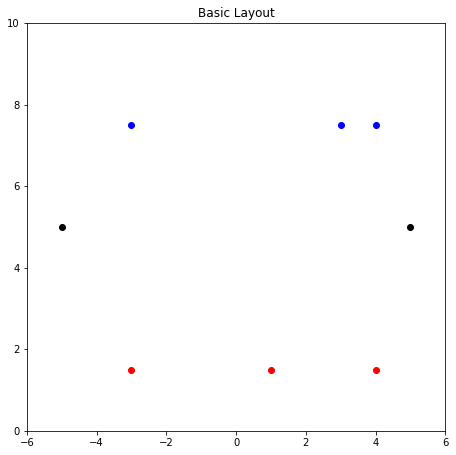

In [13]:
#creates lists of tuples of customer locations. [(4, 7.5), (3, 7.5), (-3, 7.5)]
customers = list(map(lambda x: x.get_location(), sim.customers))

#creates lists of tuples of retailer locations. [(4, 1.5), (1, 1.5), (-3, 1.5)]
retailers = list(map(lambda x: x.get_location(), sim.retailers))

fig, ax = plt.subplots()
fig.set_figheight(7.5)
fig.set_figwidth(7.5)
ax.set_xlim([-6, 6])
ax.set_ylim([0, 10])
scat = ax.scatter(*map(list,zip(*retailers)), color='r') #unpacks and plots list of tuples
scat = ax.scatter(*map(list,zip(*customers)), color='b')#unpacks and plots list of tuples
scat = ax.scatter([-5, 5], [5, 5], color='k') #unpacks and plots list of tuples
plt.title("Basic Layout")

#### Example
Insufficient power and switching drone scenario

In [14]:
np.random.seed(1)
sim = Simulation()
#List of customers and retailers
#Ensure this is the same as those in Simulation (or pass them in as arguments)
customers = [Customer(4, 7.5, "A"), Customer(3, 7.5, "B"), Customer(-3, 7.5, "C")]
retailers = [Retailer(4, 1.5, "A"), Retailer(1, 1.5, "B"), Retailer(-3, 1.5, "C")]

#Creating some orders
orders = []
orders.append(Order(customers[1], retailers[1], 0))
orders.append(Order(customers[1], retailers[2], 15))

locations, powers, orders = sim.run(orders)
locs=locations

(5, 5) None None
(5, 5) None None
(5, 5) 'Drone A' (-5, 5)
(5, 5) 'Drone A' (-5, 5)


Text(0.5, 1.0, 'Power levels for Drone A and F')

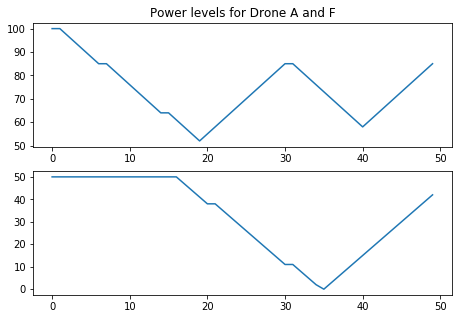

In [15]:

fig, ax = plt.subplots(2,1)
fig.set_figheight(5)
fig.set_figwidth(7.5)

for i in [0,5]:
    ax[i%4].plot(powers[:, i])
ax[0].set_title("Power levels for Drone A and F")


- Top plot is Drone A

- Bottom plot is Drone F (coming from left droneport, droneport 2)

- Drone A starts mission at timestep 0-1, goes to retailer, then customer and then returns to droneport 1 where it begins charging. 

- At timestep 15, a mission comes in which Drone F begins. It goes to retailer and then customer but has insufficient charge to return to droneport 2. It then begins to go to droneport 1 which is at full capacity at timestep 30. Simultaneously, Drone A is dispatched from droneport 1 to switch locations to droneport 2 to make room for Drone F. We see it has enough charge to make this trip. At timestep 40, it reaches droneport 2 and begins charging. 

<Figure size 540x540 with 0 Axes>

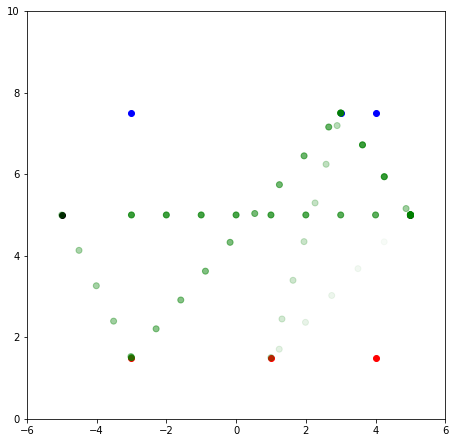

In [16]:
#creates lists of tuples of customer locations. [(4, 7.5), (3, 7.5), (-3, 7.5)]
customers = list(map(lambda x: x.get_location(), sim.customers))

#creates lists of tuples of retailer locations. [(4, 1.5), (1, 1.5), (-3, 1.5)]
retailers = list(map(lambda x: x.get_location(), sim.retailers))

n = 50
n1 = 15
n2=40
alphas = np.linspace(0.01, 1.0, 50)
rgba_colors = np.zeros((50,4))
# for red the first column needs to be one
rgba_colors[:,1] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas

plt.figure(figsize=[7.5,7.5])
fig, ax = plt.subplots()
fig.set_figheight(7.5)
fig.set_figwidth(7.5)
ax.set_xlim([-6, 6])
ax.set_ylim([0, 10])
scat = ax.scatter(*map(list,zip(*retailers)), color='r') #unpacks and plots list of tuples
scat = ax.scatter(*map(list,zip(*customers)), color='b')#unpacks and plots list of tuples
scat = ax.scatter([-5, 5], [5, 5], color='k') #unpacks and plots list of tuples

# ax.scatter(locs[:n, 0, 0], locs[:n, 0, 1], color=rgba_colors[:n, :])
rgba_colors[:,1] = 0.5
# ax.scatter(locs[n1:n2, 5, 0], locs[n1:n2, 5, 1], color=rgba_colors[:n2-n1, :])

for i in range(10):
    if (np.nonzero(np.diff(locs[:, i, 0]))[0].tolist()):
        min_ix = np.min(np.nonzero(np.diff(locs[:, i, 0])))
        max_ix = np.max(np.nonzero(np.diff(locs[:, i, 0])))
        ax.scatter(locs[min_ix:max_ix, i, 0], locs[min_ix:max_ix, i, 1], color=rgba_colors[min_ix:max_ix, :])


# for data in offsets:
#     ax.scatter(*data, alpha=0.1, color='g')

#### Random stuff

In [17]:
dp1 = DronePort(50, 50)
dp2 = DronePort(-50, 50)
fm = FleetManager(dp1, dp2)
# Drone()

In [18]:
fm.fleet
fm.update_dp_fleets()

In [19]:
dp1.fleet

['Drone A', 'Drone B', 'Drone C', 'Drone D', 'Drone E']

In [20]:
dp1
drone1 = Drone(*dp1.get_location(), 100, 100, 100, 0.5, 0.5, "A")
dp1.add_to_fleet(drone1)

In [21]:
dp1.fleet

['Drone A', 'Drone B', 'Drone C', 'Drone D', 'Drone E', 'Drone A']

In [22]:
loc = (2, 3)
loc2 = (2, 4)
np.array(loc) - np.array(loc2)
np.linalg.norm(np.array(loc)-np.array(loc2))

1.0

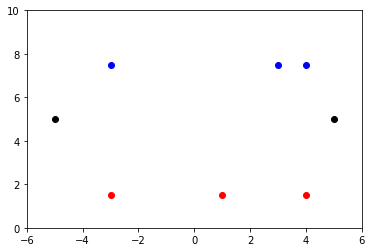

In [23]:
fig, ax = plt.subplots()
ax.set_xlim([-6, 6])
ax.set_ylim([0, 10])
scat = ax.scatter(*map(list,zip(*retailers)), color='r')
scat = ax.scatter(*map(list,zip(*customers)), color='b')
scat = ax.scatter([-5, 5], [5, 5], color='k')

# for data in offsets:
#     ax.scatter(*data, alpha=0.1, color='g')
def init():
    return scat,

def animate(offsets=locs[:, 0, :]):
    x, y = new_points
    scat.set_offsets(np.array(offsets))
    return scat

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=50, blit=True)